# <center> CSE 4/546: Reinforcement Learning
## Assignment 3 - Actor-Critic
### Part - 2: Implementing Advantage Actor Critic (A2C) - CartPole Environment

<b>Submitted By:</b><br>
Name - Shivansh Gupta<br>
UBIT No - 50604127<br>
UBIT Name - sgupta67<br>
UB Email ID - sgupta67@buffalo.edu<br>

Name - Karan Ramchandani<br>
UBIT No - 50610533<br>
UBIT Name - kramchan<br>
UB Email ID - kramchan@buffalo.edu<br>

#### Importing Required Libraries

In [14]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import time
import threading
import pickle
import numpy as np

#### Creating the required Neural Network for the A2C Model

In [3]:
# Creating an A2C Neural Network for the forward pass
class A2C_Neural_Net(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super(A2C_Neural_Net, self).__init__()
        
        # Creating a shared layer for both actor and critic
        self.shared_fc = nn.Sequential(nn.Linear(obs_dim, hidden_dim), 
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.ReLU())
        
        # Actor output head
        self.actor_fc = nn.Linear(hidden_dim, act_dim)
        
        # Critic output head
        self.critic_fc = nn.Linear(hidden_dim, 1)
        
    # Performing the forward pass
    def forward(self, state):
        state = self.shared_fc(state)
        return self.actor_fc(state), self.critic_fc(state)


#### Defining the Hyperparameters

In [5]:
lr = 1e-4   
gamma = 0.995    
sync_steps = 6        
episodes = 2000     
worker_num = 4       
entropy_coeff = 0.01 
grad_clipped = 0.5  

#### Creating a Worker Function to perform A2C Algorithm

In [ ]:
# Defining the worker function which will be run in parallel using multiprocessing and will interact with the environment and update the global model
def Worker_function(worker_id, env_name, global_model, optimizer, reward_queue, 
                    lock, gamma, sync_steps, entropy_coff):
    
    torch.manual_seed(worker_id)
    
    # Initiating the environment
    train_env = gym.make(env_name)
    observation_dim = train_env.observation_space.shape[0]
    action_dim = train_env.action_space.n
    
    # Creating the local model for training using the defined neural network
    local_model = A2C_Neural_Net(observation_dim, action_dim)
    local_model.load_state_dict(global_model.state_dict())
    
    step = 1
    ep_reward = 0
    curr_state, _ = train_env.reset()
    done = False
    
    # Running the episode until it is terminated or truncated
    while True:
        
        # Creating the variables to store the transitions for each episode
        rewards, values, log_probabilities, entropies = [], [], [], []
        state_t = torch.tensor(curr_state, dtype=torch.float32).unsqueeze(0)
        logit, value = local_model(state_t)
        
        # Sampling action from the policy using the softmax distribution and calculating the entropy
        distributions = torch.distributions.Categorical(logits=logit)
        action_taken = distributions.sample()
        log_probability = distributions.log_prob(action_taken)
        entropy = distributions.entropy()
        
        # Taking the action in the environment and getting the next state informations
        next_state, reward, terminated, truncated, _ = train_env.step(action_taken.item())
        done = truncated or terminated
        
        # Storing the transitions and other values recieived from the environment
        rewards.append(reward)
        values.append(value.squeeze(0))
        log_probabilities.append(log_probability)
        entropies.append(entropy)
        
        # Sync stpes = 5 befor the next update
        if step % sync_steps == 0 or done:
            
            # Calculating the GT rewards
            if done:
                GT_Reward = 0.0
            else:
                nextstate_t = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad(): 
                    _, value_next = local_model(nextstate_t)
                    GT_Reward = value_next.item()

            # Reversing the rewards and calculating the returns
            returns = []
            for rew in reversed(rewards):
                GT_Reward = rew + gamma * GT_Reward
                returns.insert(0, GT_Reward)

            # Computing the loss for actor and critic using the advantage
            actor_loss = 0
            critic_loss = 0
            for a, b, c, d in zip(returns, values, log_probabilities, entropies):
                advantage = a - b
                actor_loss  += -c * advantage - entropy_coff * d
                critic_loss += advantage.pow(2)

            # Total loss computation
            total_loss = actor_loss + critic_loss
            
            # Performing Backpropagation to optimize the model
            total_loss.backward()
            
            # Locking the parameter to sync
            with lock:
                optimizer.zero_grad()
                for shared_p, local_p in zip(global_model.parameters(), local_model.parameters()):
                    if local_p.grad is not None:
                        shared_p.grad = local_p.grad.clone() if shared_p.grad is None else shared_p.grad + local_p.grad.clone()
                        
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(global_model.parameters(), grad_clipped)
                optimizer.step()
                local_model.load_state_dict(global_model.state_dict())

            local_model.zero_grad()
            
            # Emptiying the queues for the next episode
            rewards.clear()
            values.clear()
            log_probabilities.clear()
            entropies.clear()
            
        curr_state = next_state
        ep_reward += reward
        
        step += 1
        
        if done:
            # Adding the episode reward to the queue for plotting
            reward_queue.put(ep_reward)
            ep_reward = 0
            step = 1
            curr_state, _ = train_env.reset()

#### Creating a Training Loop to record all the observations

In [ ]:
# Defining the training loop to record the observations
def training_loop(reward_queue, plot_rewards_arr, num_eps):
    
    # Running for total number of episodes
    for ep in range(num_eps):
        time.sleep(0.1)
        Sum_rewards, Count_rewards = 0, 0
        
        while not reward_queue.empty():
            Sum_rewards += reward_queue.get()
            Count_rewards += 1
        
        if Count_rewards > 0:
            plot_rewards_arr.append(Sum_rewards / Count_rewards)
        else:
            plot_rewards_arr.append(0)
        
        if ep % 50 == 0 and ep > 0 and Count_rewards > 0:
            print(f"Episode No: {ep} | Reward: {(Sum_rewards / Count_rewards):.2f}")

#### Creating a Worker Training Function to perform the training using multithreading over multiple workers

In [ ]:
# Defining the training function to perform training across multiple workers using python multiple processing
def worker_training():
    
    # Initializing the environment
    train_env_name = 'CartPole-v1'
    train_env = gym.make(train_env_name)
    observation_dim = train_env.observation_space.shape[0]
    action_dim = train_env.action_space.n
    
    # Creating the global model and sharing it across processes
    global_model = A2C_Neural_Net(observation_dim, action_dim)
    global_model.share_memory()
    optimizer = optim.Adam(global_model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Creating a queue to store the rewards for plotting
    reward_queue = mp.Queue()
    lock = mp.Lock()
    
    # Creating the workers for parallel processing and adding them to train
    processes = []
    print("=====Training Start=====")
    for wid in range(worker_num):
        print(f"Worker {wid+1} started")
        proc = mp.Process(target=Worker_function, args=(wid, train_env_name, global_model, optimizer, reward_queue, lock, gamma, sync_steps, entropy_coeff))
        proc.start()
        processes.append(proc)
        
    plot_rewards_arr = []

    # Waiting for the workers to finish training and collecting the rewards
    train_loop = threading.Thread(target=training_loop, args=(reward_queue, plot_rewards_arr, episodes), daemon=True)
    train_loop.start()
    train_loop.join()
    
    # Joining the workers in the end
    for proc in processes:
        proc.terminate()
        proc.join()
    
    # Saving the trained model and the rewards as pickle files
    checkpoint = {
        'state_dict': global_model.state_dict(),
        'returns':    plot_rewards_arr
    }
    
    with open('a3_part_2_a2c_cartpole_sgupta67_karamchan.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("Saved the weights a3_part_2_a2c_cartpole_sgupta67_karamchan.pkl")

#### Training the agent and storing the Weights in a pickle file

In [ ]:
mp.set_start_method('spawn')
worker_training()

#### Loading the rewards of the learned model to plot the trend

In [12]:
model_weights = pickle.load(open('a3_part_2_a2c_cartpole_sgupta67_karamchan.pkl', 'rb'))
rewards = model_weights['returns']

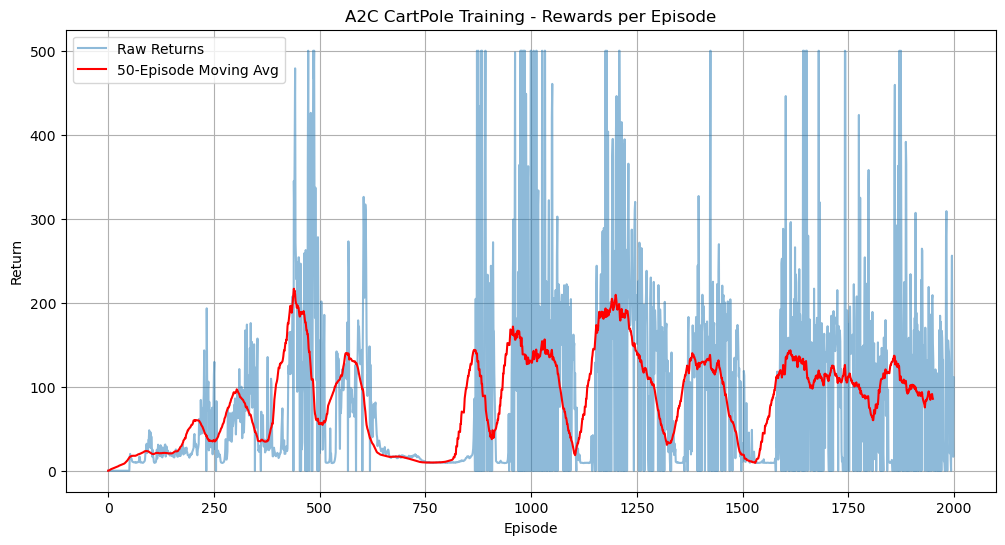

In [20]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C CartPole Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Testing the trained model for 10 Greedy Episodes

In [22]:
test_env = gym.make('CartPole-v1')
observation_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n
test_env.close()

# Initializing the network
test_model = A2C_Neural_Net(observation_dim, action_dim)

# Loading the trained model weights
network_weights = pickle.load(open('a3_part_2_a2c_cartpole_sgupta67_karamchan.pkl', 'rb'))
test_model.load_state_dict(network_weights['state_dict'])
test_model.eval()

greedy_rewards = []

# Testing the trained model for 10 episodes
for ep in range(10):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logit, value = test_model(state_t)
        distributions = torch.distributions.Categorical(logits=logit)
        action_taken = distributions.sample()
        next_state, reward, terminated, truncated, _ = test_env.step(action_taken.item())
        done = truncated or terminated
        total_reward += reward
        state = next_state
        
    print(f"Episode: {ep} Total_reward: {total_reward}")
    greedy_rewards.append(total_reward)
    test_env.close()

Episode: 0 Total_reward: 454.0
Episode: 1 Total_reward: 500.0
Episode: 2 Total_reward: 500.0
Episode: 3 Total_reward: 500.0
Episode: 4 Total_reward: 444.0
Episode: 5 Total_reward: 414.0
Episode: 6 Total_reward: 500.0
Episode: 7 Total_reward: 405.0
Episode: 8 Total_reward: 416.0
Episode: 9 Total_reward: 500.0


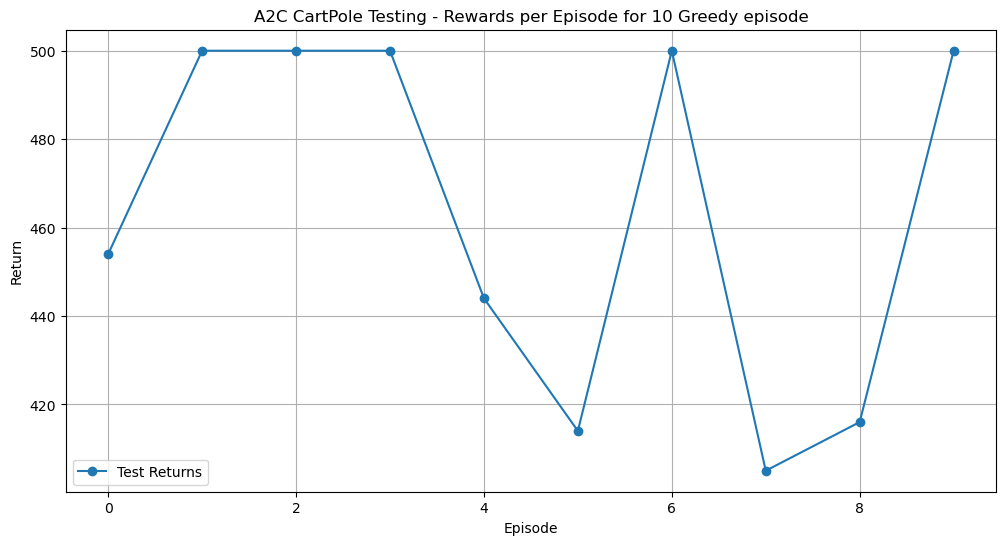

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards, marker='o', label='Test Returns')
plt.title("A2C CartPole Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()